     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
## Import Script for Libraries - Script to convert the file into CSV and load the parquet file
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import chi2_contingency
import seaborn as sns
import random

import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau

In [2]:
## [Data Import & potential storing]
# File Origin
parquet_file_path = '/Users/PS/Library/CloudStorage/GoogleDrive-pascal@ephema.io/Meine Ablage/ephema/Code/ET/MEVBoost Analysis/openethdata_eth_data.parquet.gzip'
parquet_file_path_mapping = '/Users/PS/Library/CloudStorage/GoogleDrive-pascal@ephema.io/Meine Ablage/ephema/Code/ET/MEVBoost Analysis/openethdata_validator_data.parquet.gzip'
# File Stored
csv_file_path = '/Users/PS/Library/CloudStorage/GoogleDrive-pascal@ephema.io/Meine Ablage/ephema/Code/ET/MEVBoost Analysis/MEVBoost_CSV.csv'
csv_file_path_mapping = '/Users/PS/Library/CloudStorage/GoogleDrive-pascal@ephema.io/Meine Ablage/ephema/Code/ET/MEVBoost Analysis/MEVBoost_Mapping_CSV.csv'

# Reading the Parquet file
mev_boost_data = pd.read_parquet(parquet_file_path)
mev_mapping_data = pd.read_parquet(parquet_file_path_mapping)

# Ensuring right formatting & sorting
mev_boost_data['date'] = pd.to_datetime(mev_boost_data['date'])
mev_boost_data = mev_boost_data.sort_values(by='date')

## Saving the DataFrame as a CSV file // file 1.2GB as csv so not saving it locally for now
# mev_boost_data.to_csv(csv_file_path, index=False)
# mev_mapping_data.to_csv(csv_file_path_mapping, index=False)

# print(f"File converted and saved as {csv_file_path}")

In [26]:
## Data Inspection

# mev_boost_data.tail(500).to_csv('/Users/PS/Library/CloudStorage/GoogleDrive-pascal@ephema.io/Meine Ablage/ephema/Code/ET/MEVBoost Analysis/MEVBoost_500_CSV.csv', index = False)
# mev_boost_data.head(5)

,date,slot,block_number,relay,builder_pubkey,proposer_pubkey,mevboost_value,builder,validator
500118,2022-09-15 06:42:59,4700013,15537394.0,None,None,0xa04520c5c37237e358cdd10d75d055d2e81ada151e63...,None,None,celsius
1897668,2022-09-15 06:43:11,4700014,15537395.0,None,None,0xa605e658a0dd0dd77adb9fc2398f78f24c648125126d...,None,None,stakehound
562765,2022-09-15 06:43:23,4700015,15537396.0,None,None,0xb11a32a0f8f7acb81f959e7c68af49705bb64d78b41b...,None,None,lido
2812199,2022-09-15 06:43:35,4700016,15537397.0,None,None,0x863b410dfb618b4f6b947f3ede710001aa274bc74b1d...,None,None,binance
1690921,2022-09-15 06:43:47,4700017,15537398.0,None,None,0xb9be1d7a0a871eef07ca47796842b0449032462d69d2...,None,None,0xb9be1d7a0a871eef07ca47796842b0449032462d69d2...


In [77]:
## [Exploratory Data Analysis] No data transformation

num_rows = len(mev_boost_data)
non_empty_count = mev_boost_data[mev_boost_data['mevboost_value'].notna() & (mev_boost_data['mevboost_value'] != '')].shape[0]
non_empty_count_builder = mev_boost_data[mev_boost_data['builder_pubkey'].notna() & (mev_boost_data['builder_pubkey'] != '')].shape[0]
non_empty_count_proposer = mev_boost_data[mev_boost_data['proposer_pubkey'].notna() & (mev_boost_data['proposer_pubkey'] != '')].shape[0]
percentage_non_empty_mev = non_empty_count / num_rows
num_unique_slots = mev_boost_data['slot'].nunique()
non_unique_slots = num_rows - num_unique_slots
num_unique_blocks = mev_boost_data['block_number'].nunique()
print(f"Number of non-empty entries in 'mevboost_value': {non_empty_count}")
print(f"Number of Unique Slots: {num_unique_slots}")
print(f"Number of Non-Unique Slots: {non_unique_slots}")
print(f"Number of Unique Blocks': {num_unique_blocks}")
print(f"Number of non-empty entries in 'builder_pubkey': {non_empty_count_builder}")
print(f"Number of non-empty entries in 'proposer_pubkey': {non_empty_count_proposer}")
print(f"Percentage non-empty MEV Values: {percentage_non_empty_mev}")
print(f"Number of entries: {num_rows}")

Number of non-empty entries in 'mevboost_value': 3149325
Number of Unique Slots: 2863656
Number of Non-Unique Slots: 719539
Number of Unique Blocks': 2835688
Number of non-empty entries in 'builder_pubkey': 3149325
Number of non-empty entries in 'proposer_pubkey': 3583146
Percentage non-empty MEV Values: 0.8789153255683824
Number of entries: 3583195


In [3]:
## [Data Cleaning] Time intense data cleaning of duplicate entries (for certain entries multiple rows with the same data only different relays are in the dataset)
# Information will be collapsed into one entry and relay information will be stored as a nested list


# Group by unique slot # values (collapse all others into lists)
mev_boost_data_collapsed = mev_boost_data.groupby('slot').agg(lambda x: list(x)).reset_index()

# Sort data chronologically 
mev_boost_data_collapsed = mev_boost_data_collapsed.sort_values(by='date')

In [4]:
## [Data Processing] Unnest the data for easier handling later and reduce duplicate values in lists. Note, that 0 values are excluded. This could be relevant for MEV values, to be checked later.

def unnest_or_condense(x):

    if not isinstance(x, list):
        return x  # Return the input as-is if it's not a list
    
    # Find the first non-None, non-empty, and non-'0.0' item in the list for comparison
    comparison_base = next((item for item in x if not pd.isna(item) and item not in ['', '0.0',0.0]), None)
    
    # If no valid comparison base found, return None or keep as list based on your preference
    if comparison_base is None:
        return None
    
    # Check if all non-None, non-empty, and non-'0.0' items in the list are the same as the comparison base
    if all(pd.isna(elem) or elem == comparison_base or elem in ['', '0',0.0] for elem in x):
        return comparison_base  # Return the comparison base if condition is met

    # Filter out None, '', '0.0' from the list for the final return
    filtered_x = [elem for elem in x if not pd.isna(elem) and elem not in ['', '0',0.0]]
    return filtered_x if filtered_x else None  # Return filtered list, or None if it becomes empty


# Specified columns to unnest or condense
columns_to_process = ['date','block_number', 'builder_pubkey','proposer_pubkey','mevboost_value','builder','validator']

mev_boost_data_clean = mev_boost_data_collapsed

for col in columns_to_process:
    mev_boost_data_collapsed[col] = mev_boost_data_clean[col].apply(unnest_or_condense)

In [5]:
# [DATA Sanity] Check to see how many duplicate values exist in each column.

columns_to_check = ['date','block_number', 
                    'relay', 
                    'builder_pubkey',
                    'proposer_pubkey','mevboost_value','builder','validator']  # List of column names to check

pd.set_option('display.max_colwidth', None)

for col in columns_to_check:
    rows_with_lists = mev_boost_data_clean[mev_boost_data_clean[col].apply(lambda x: isinstance(x, list))]
    count_rows_with_lists = mev_boost_data_clean[col].apply(lambda x: isinstance(x, list)).sum()

    if not rows_with_lists.empty:
        #print(f"Rows with lists in '{col}':")
        print(f"Rows with lists in '{col}': {count_rows_with_lists}")
        #print(rows_with_lists)
    else:
        print(f"No lists found in '{col}'.")

No lists found in 'date'.
No lists found in 'block_number'.
Rows with lists in 'relay': 2863656
Rows with lists in 'builder_pubkey': 17958
No lists found in 'proposer_pubkey'.
Rows with lists in 'mevboost_value': 13
Rows with lists in 'builder': 6
No lists found in 'validator'.


In [5]:
## [Data Pre-Processing] - Based on the data analysis only very few incidents exist for duplicate values in mevboost_value & builder (<20)
# Hence they will be reduced for easier data handeling

def average_mev_boost(x):
    # Check if the input is a list
    if isinstance(x, list):
        # Convert all elements to numbers, ignoring NaNs
        numeric_values = pd.to_numeric(x, errors='coerce')
        # Calculate and return the average, ignoring NaNs
        return np.nanmean(numeric_values)
    # Return the input as is if it's not a list
    return x

# For MEV_boost payments we will take the average payment and ensure the data is in numeric format
mev_boost_data_clean['mevboost_value'] = mev_boost_data_clean['mevboost_value'].apply(average_mev_boost)
mev_boost_data_clean['mevboost_value'] = pd.to_numeric(mev_boost_data_clean['mevboost_value'], errors='coerce')

# For the Builder Column values are set manually based on information found on Etherscan
# Block #17034938 https://etherscan.io/block/17034938 - manta-builder 
# Block #17035147 https://etherscan.io/block/17035147 - rsync-builder.xyz 
# Block #17035222 https://etherscan.io/block/17035222 - manta-builder 
# Block #17035228 https://etherscan.io/block/17035228 - manta-builder
# Block #17363100 https://etherscan.io/block/17363100 - aequitas et integritas
# Block #17655322 https://etherscan.io/block/17655322 - aequitas et integritas

# Manually set the builder values for specific blocks
block_builder_mapping = {
    17034938: 'manta-builder',
    17035147: 'rsync-builder.xyz',
    17035222: 'manta-builder',
    17035228: 'manta-builder',
    17363100: 'aequitas et integritas',
    17655322: 'aequitas et integritas'
}

for block_number, builder_name in block_builder_mapping.items():
    # Use .loc to find rows where the block_number matches and set the builder column
    mev_boost_data_clean.loc[mev_boost_data_clean['block_number'] == block_number, 'builder'] = builder_name

print(mev_boost_data_clean.columns)    
## From here onward mev_boost_data_clean should not be corrupted anymore (DOUBLE CHECK!)

Index(['slot', 'date', 'block_number', 'relay', 'builder_pubkey',
       'proposer_pubkey', 'mevboost_value', 'builder', 'validator'],
      dtype='object')


In [6]:
## [Sanity Check] - No Data Transformation

print("Number of Data Entries:", len(mev_boost_data_clean))
print("Number of Empty Slots:")
na_counts_clean_data = mev_boost_data_clean.isna().sum()
print(na_counts_clean_data)

mev_boost_data_clean_sorted = mev_boost_data_clean.sort_values('slot')

# Calculate differences between consecutive slots
mev_boost_data_clean_sorted['slot_diff'] = mev_boost_data_clean_sorted['slot'].diff()

# Non-consecutive slots
non_consecutive_slots_mbdcs = mev_boost_data_clean_sorted[mev_boost_data_clean_sorted['slot_diff'] != 1]
non_consecutive_count_mbdcs = (mev_boost_data_clean_sorted['slot_diff'] != 1).sum()

print(f"Number of non-consecutive slots: {non_consecutive_count_mbdcs}")
print(f"Non-consecutive slots found at:")
print(non_consecutive_slots_mbdcs['slot'])

Number of Data Entries: 2863656
Number of Empty Slots:
slot                    0
date                    0
block_number        22255
relay                   0
builder_pubkey     433870
proposer_pubkey        13
mevboost_value     433874
builder            433870
validator              13
dtype: int64
Number of non-consecutive slots: 9
Non-consecutive slots found at:
0          4700013
1702084    6402112
1911929    6612045
1911930    6612047
1911940    6612058
1912023    6612207
1912035    6612327
2014044    6714349
2014045    6714351
Name: slot, dtype: int64


In [8]:
## [Data Analysis] - No Transformation - Number of Unique Builders and Validators
#mev_boost_data_clean.tail()
num_unique_builder = mev_boost_data_clean['builder'].nunique()
num_unique_validator = mev_boost_data['validator'].nunique()
print(f"Number of Unique Builders in the Data Set '{num_unique_builder}'.")
print(f"Number of Unique Validators in the Data Set '{num_unique_validator}'.")

Number of Unique Builders in the Data Set '128'.
Number of Unique Validators in the Data Set '221806'.


In [15]:
# [Analysis] Calculate mean, ignoring NaN values

empty_values_count = mev_boost_data_clean['mevboost_value'].isna().sum()
mean_value = mev_boost_data_clean['mevboost_value'].mean()
mean_value_in_eth = mean_value / (10**18)
# Calculate median, ignoring NaN values
median_value = mev_boost_data_clean['mevboost_value'].median()
median_value_in_eth = median_value / (10**18)

print(f"Empty Values in mevboost_value: {empty_values_count}")
print(f"Mean MEVBoost Payment: {mean_value_in_eth}")
print(f"Median of MEVBoost Payment: {median_value_in_eth}")

Empty Values in mevboost_value: 433874
Mean MEVBoost Payment: 0.12845403605642955
Median of MEVBoost Payment: 0.05114313259110733


In [16]:
# [Analysis] Statistics

mevboost_value = mev_boost_data_clean['mevboost_value']

# Convert decimal.Decimal values to float
mevboost_value = mevboost_value.astype(float)

# Mean
mean_value = mevboost_value.mean()

# Median
median_value = mevboost_value.median()

# Mode (may have multiple modes, hence the Series)
mode_values = mevboost_value.mode()

# Standard Deviation
std_deviation = mevboost_value.std()

# Minimum
min_value = mevboost_value.min()

# Maximum
max_value = mevboost_value.max()

# Range
data_range = max_value - min_value

# Percentiles (e.g., 25th, 50th, and 75th percentiles)
percentiles = mevboost_value.quantile([0.25, 0.5, 0.75])

# Skewness
skewness = mevboost_value.skew()

# Kurtosis
kurtosis = mevboost_value.kurtosis()

# Display the computed statistics
print("Mean:", mean_value)
print("Median:", median_value)
print("Mode:", mode_values.tolist())  # Convert to list to handle multiple modes
print("Standard Deviation:", std_deviation)
print("Minimum:", min_value)
print("Maximum:", max_value)
print("Range:", data_range)
print("25th, 50th, and 75th Percentiles:", percentiles.tolist())
print("Skewness:", skewness)
print("Kurtosis:", kurtosis)

Mean: 1.2845403605642954e+17
Median: 5.114313259110733e+16
Mode: [3.4543546433999996e+16]
Standard Deviation: 1.332590981437496e+18
Minimum: 19984464565687.0
Maximum: 6.919631922654178e+20
Range: 6.919631722809532e+20
25th, 50th, and 75th Percentiles: [3.0753692059875384e+16, 5.114313259110733e+16, 9.724352462524317e+16]
Skewness: 276.3449530130587
Kurtosis: 112785.31925506836


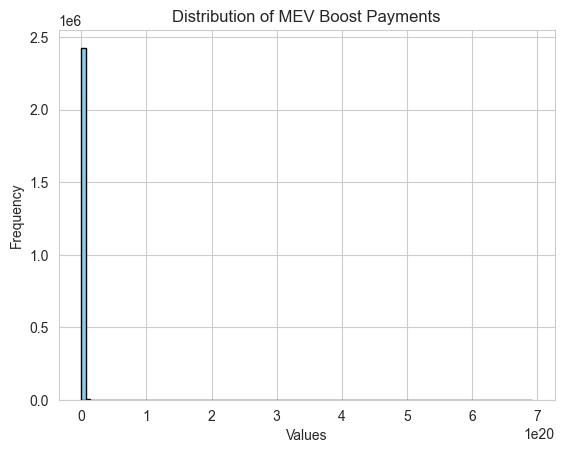

<Figure size 640x480 with 0 Axes>

In [85]:
# [Visualization]
# Plot histogram
plt.hist(mevboost_value, bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of MEV Boost Payments')

# Show plot
plt.show()
plt.savefig('Results/Distribution of MEV Boost Payments.png')

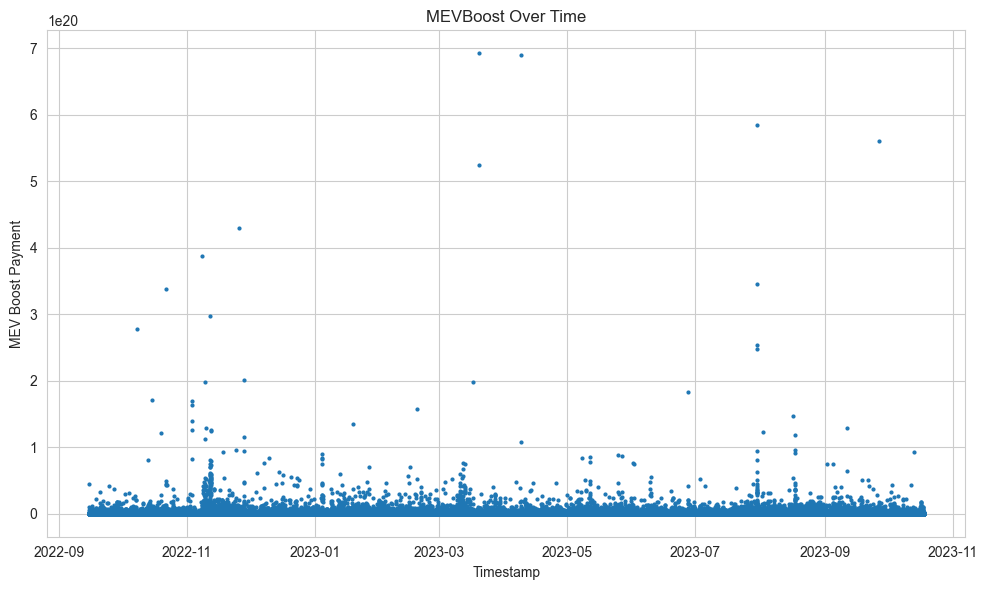

In [86]:
# [Visualization] MEV Over Time
mev_boost_data_sorted = mev_boost_data_clean.sort_values(by='date')

# Plot the data over time
plt.figure(figsize=(10, 6))
plt.plot(mev_boost_data_sorted['date'], mev_boost_data_sorted['mevboost_value'], marker='o', markersize=2, linestyle='')
plt.xlabel('Timestamp')
plt.ylabel('MEV Boost Payment')
plt.title('MEVBoost Over Time')
plt.grid(True)
plt.tight_layout()
plt.savefig('Results/MEVBoost Payments over Time.png')
plt.show()


       Pearson All  Pearson Top 50%  Spearman All  Spearman Top 50%  \
Shift                                                                 
1         0.269411         0.225540      0.383948          0.204985   
2         0.078253         0.086739      0.335367          0.167435   
3         0.089642         0.053942      0.321372          0.155519   
4         0.058127         0.041423      0.310488          0.147867   
5         0.042336         0.036089      0.309635          0.142317   
6         0.038571         0.031211      0.296616          0.138603   
7         0.030126         0.026921      0.294633          0.134707   
8         0.024321         0.023007      0.288206          0.131928   
9         0.028356         0.033317      0.285951          0.131553   
10        0.025160         0.019987      0.287792          0.127447   
11        0.028564         0.024056      0.279283          0.125694   
12        0.027079         0.022017      0.277821          0.123792   
13    

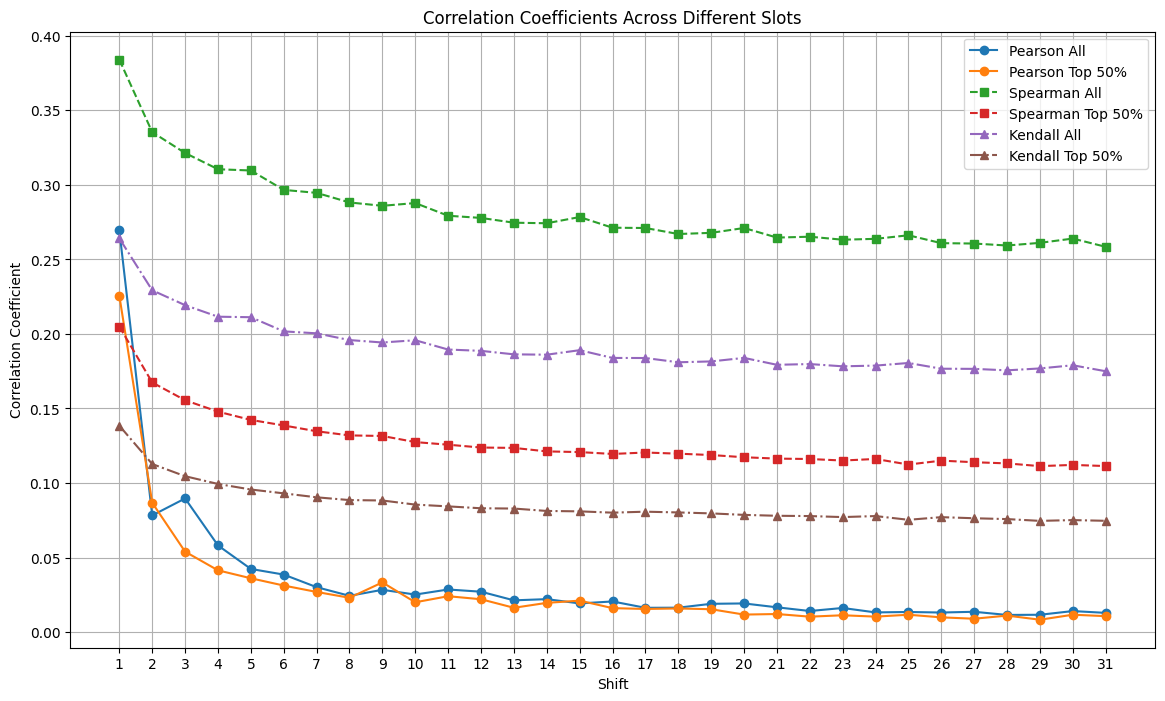

In [9]:
## [Analysis & Visualization] calculating the correlation between consecutive values to understand if MEV is seasonal

# sorting the data first
mev_boost_data_sorted = mev_boost_data_clean.sort_values(by='date')
mevboost_value = mev_boost_data_sorted['mevboost_value']

# Convert decimal.Decimal values to float
mevboost_value = mevboost_value.astype(float)

# Sanity Check: Only use top 50% data
cutoff = mevboost_value.quantile(0.5)
top_50_p_values = mevboost_value[mevboost_value > cutoff]

# Optimized way to calculate correlations for various shifts, including the top 50%
shifts = range(1, 32)  # Considering shifts for one epoch
results = []  # To store the results for each shift

# Loop through each shift
for shift in shifts:
    shifted_data = mevboost_value.shift(shift)
    shifted_data_50 = top_50_p_values.shift(shift)
    
    # For all data
    concatenated_data = pd.concat([mevboost_value, shifted_data], axis=1).dropna()
    pearson_corr = pearsonr(concatenated_data.iloc[:, 0], concatenated_data.iloc[:, 1])[0]
    spearman_corr = spearmanr(concatenated_data.iloc[:, 0], concatenated_data.iloc[:, 1])[0]
    kendall_corr = kendalltau(concatenated_data.iloc[:, 0], concatenated_data.iloc[:, 1])[0]
    
    # For top 50% data
    concatenated_data_50 = pd.concat([top_50_p_values, shifted_data_50], axis=1).dropna()
    pearson_corr_50 = pearsonr(concatenated_data_50.iloc[:, 0], concatenated_data_50.iloc[:, 1])[0]
    spearman_corr_50 = spearmanr(concatenated_data_50.iloc[:, 0], concatenated_data_50.iloc[:, 1])[0]
    kendall_corr_50 = kendalltau(concatenated_data_50.iloc[:, 0], concatenated_data_50.iloc[:, 1])[0]
    
    # Store the results
    results.append({
        'Shift': shift,
        'Pearson All': pearson_corr,
        'Pearson Top 50%': pearson_corr_50,
        'Spearman All': spearman_corr,
        'Spearman Top 50%': spearman_corr_50,
        'Kendall All': kendall_corr,
        'Kendall Top 50%': kendall_corr_50,
    })

# Convert results to a DataFrame for a neat table
results_df = pd.DataFrame(results)
results_df.set_index('Shift', inplace=True)

## Display the results table
print(results_df)

# Assuming `results_df` is your DataFrame containing the correlation results
shifts = results_df.index.values

# Plotting
plt.figure(figsize=(14, 8))

# Pearson
plt.plot(shifts, results_df['Pearson All'], marker='o', linestyle='-', label='Pearson All')
plt.plot(shifts, results_df['Pearson Top 50%'], marker='o', linestyle='-', label='Pearson Top 50%')

# Spearman
plt.plot(shifts, results_df['Spearman All'], marker='s', linestyle='--', label='Spearman All')
plt.plot(shifts, results_df['Spearman Top 50%'], marker='s', linestyle='--', label='Spearman Top 50%')

# Kendall
plt.plot(shifts, results_df['Kendall All'], marker='^', linestyle='-.', label='Kendall All')
plt.plot(shifts, results_df['Kendall Top 50%'], marker='^', linestyle='-.', label='Kendall Top 50%')

# Adding legend
plt.legend()

# Titles and labels
plt.title('Correlation Coefficients Across Different Slots')
plt.xlabel('Shift')
plt.ylabel('Correlation Coefficient')
plt.xticks(shifts)  # Ensure we have a tick for every shift value

# Display the plot
plt.grid(True)
plt.savefig('Results/Correlation_Coefficients.png')  # Saves the plot as a PNG file
plt.show()


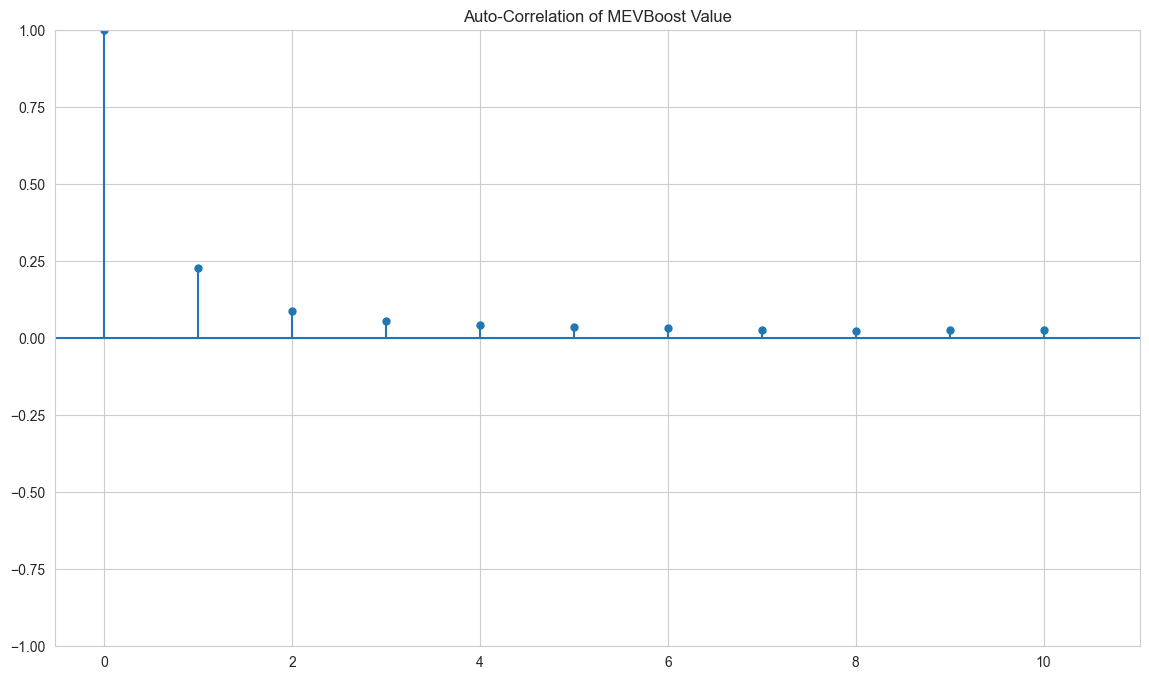

In [88]:
## [Visualization] Additionally auto-correlation is measured - time-intensive

# Assuming mevboost_value is your time series data of interest
mevboost_value = mev_boost_data_clean['mevboost_value'].dropna().astype(float)

# Calculate and visualize the auto-correlation
fig, ax = plt.subplots(figsize=(14, 8))
plot_acf(mevboost_value, ax=ax, lags=10)  # Using 31 lags as an example, adjust based on your dataset

# Show the plot
plt.title('Auto-Correlation of MEVBoost Value')
plt.savefig('Results/Auto-Correlation.png')  # Saves the plot as a PNG file
plt.show()

In [ ]:
mev_boost_data_clean.tail(100)

In [13]:
## [Analysis] Excursus: Measuring correlation of Builder & Proposer

mev_boost_data_clean_09_2023 = mev_boost_data_clean[
    (mev_boost_data_clean['date'].dt.year == 2023) & (mev_boost_data_clean['date'].dt.month == 9)]


#contingency_table = pd.crosstab(mev_boost_data_clean_09_2023['builder'], mev_boost_data_clean_09_2023['validator'])
contingency_table = pd.crosstab(mev_boost_data_clean['builder'], mev_boost_data_clean['validator'])
contigency_table_complete = contingency_table

total_slots = contingency_table.values.sum()

# Identify validators & builders with less than 1% of the total slots
validators_below_1pct = contingency_table.columns[contingency_table.sum(axis=0) < total_slots * 0.01]
builders_below_1pct = contingency_table.index[contingency_table.sum(axis=1) < total_slots * 0.01]

# Aggregate counts for validators and builders below 1% into "Other" categories
other_validator_counts = contingency_table[validators_below_1pct].sum(axis=1)
other_builder_counts = contingency_table.loc[builders_below_1pct].sum(axis=0)

# Aggregate counts for "Other" validators and builders
contingency_table['Other Validator'] = contingency_table[validators_below_1pct].sum(axis=1)
other_builder_counts = contingency_table.loc[builders_below_1pct].sum(axis=0)
contingency_table = contingency_table.drop(columns=validators_below_1pct)
contingency_table = contingency_table.drop(builders_below_1pct)

# Append "Other" builder counts as a new row
other_builder_counts['Other Validator'] = contingency_table['Other Validator'].sum()  # Including the sum for the "Other Validator" column
contingency_table.loc['Other Builder'] = other_builder_counts

# Ensure no NaN values
contingency_table.fillna(0, inplace=True)

# Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# print(contingency_table)
print(f"Chi-Square Statistic: {chi2}, p-value: {p}")


## Save the contingency table to a CSV file
#contingency_table.to_csv('/Users/PS/Library/CloudStorage/GoogleDrive-pascal@ephema.io/Meine Ablage/ephema/Code/ET/MEVBoost Analysis/Contigency_table.csv', index=True)

Chi-Square Statistic: 915192.7814261264, p-value: 0.0


In [14]:
## [Visualization] Excursus 2: Observed vs. statistical occurence of Builder-Validator Cooperation
# Needs data from excursus 1

validator_slot_sum = contingency_table.sum(axis=0)
builder_slot_sum = contingency_table.sum(axis=1)
total_slots = contingency_table.values.sum()

# Calculate expected slots for each builder-validator combination
expected_slots = pd.DataFrame(index=contingency_table.index, columns=contingency_table.columns)
for validator in contingency_table.columns:
    for builder in contingency_table.index:
        expected_value = (builder_slot_sum[builder] * validator_slot_sum[validator]) / total_slots
        expected_slots.at[builder, validator] = round(expected_value)

# Calculate deviance between observed and expected slots
deviance = contingency_table - expected_slots

# Print the expected slots and the deviance to observe the differences
print("Expected Slots:")
print(expected_slots)
print("\nDeviance (Observed - Expected):")
print(deviance)

## Relative Deviance calculated as well

# Ensure expected_slots is in the correct numeric type for operations
expected_slots = expected_slots.astype(float)

# Calculate relative deviance as a percentage
relative_deviance = ((contingency_table - expected_slots) / expected_slots) * 100

# Handle divisions by zero or where expected slots are zero by replacing NaN or infinite values with an appropriate marker
relative_deviance.replace([np.inf, -np.inf], np.nan, inplace=True)  # Option to replace infinite values with NaN
relative_deviance.fillna(0, inplace=True)  # Replacing NaNs with 0 or another placeholder if preferred

print("Relative Deviance (%):")
print(relative_deviance)

Expected Slots:
validator               abyss finance binance bitcoin suisse celsius coinbase  \
builder                                                                         
BloXroute                        1465    7614           2915    1358    13669   
Blocknative                       626    3253           1245     580     5840   
Flashbots                        4055   21069           8067    3759    37826   
Geth Go                           334    1733            664     309     3111   
Titan Builder                    1384    7190           2753    1283    12909   
beaverbuild.org                  4348   22596           8651    4031    40567   
builder0x69                      3908   20310           7776    3624    36463   
f1b.io                            276    1432            548     255     2571   
https://edennetwork.io            224    1164            445     208     2089   
https://eth-builder.com           437    2269            869     405     4074   
rsync-builde

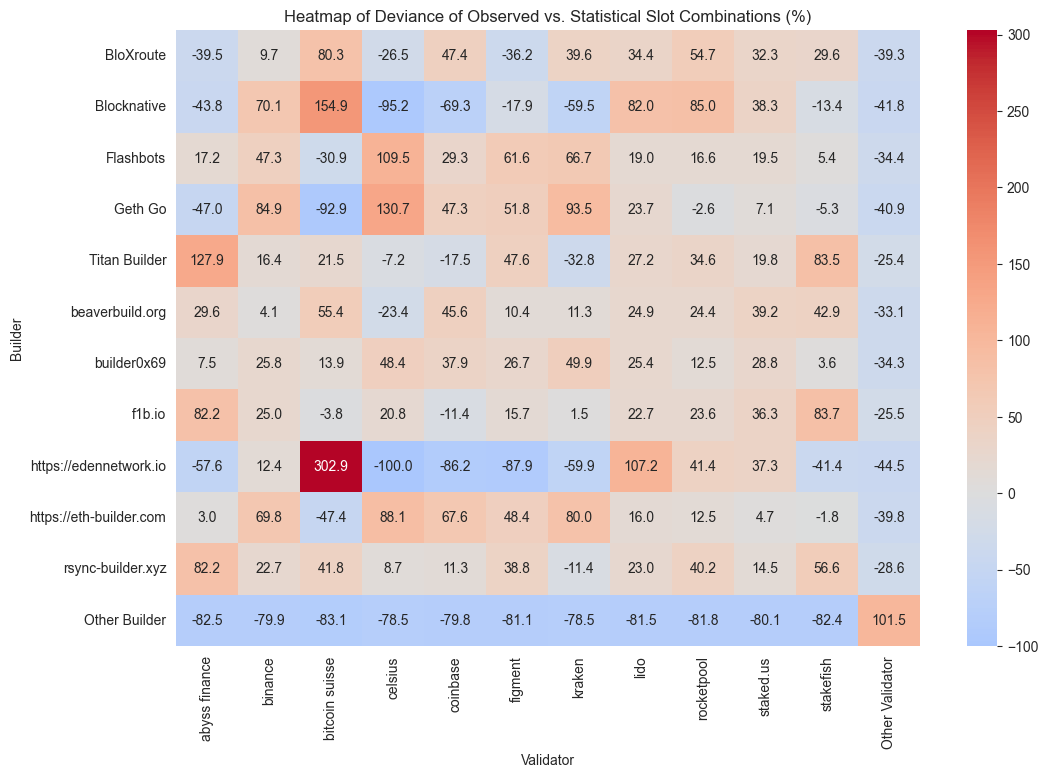

In [55]:
# [Visualization] Plot Heatmap (Excursus 1 & 2 required to run before)
plt.figure(figsize=(12, 8))
sns.heatmap(relative_deviance, cmap='coolwarm', fmt=".1f", annot=True, center=0)
plt.title('Heatmap of Deviance of Observed vs. Statistical Slot Combinations (%)')
plt.xlabel('Validator')
plt.ylabel('Builder')
plt.show()

## To Do: check if the deviance comes from correlated high market shares

In [15]:
## [Data Transformation & Analysis] Builder marketshare

## Check number of rows and NA values
#total_rows = mev_boost_data_clean.shape[0]
#print(f"Total number of rows in mev_boost_data_clean: {total_rows}")
#na_values_count = mev_boost_data_clean['builder'].isna().sum()
#print(f"Number of NA values in the 'builder' column: {na_values_count}")

# Count unique occurrences of each builder name
builder_counts = mev_boost_data_clean['builder'].value_counts()

# Calculate the total number of entries with a builder name
total_builder_slots = builder_counts.sum()

# Convert builder_counts Series to a DataFrame and calculate market share
builder_counts_df = builder_counts.reset_index()
builder_counts_df.columns = ['Builder', 'Count']
builder_counts_df['Market Share (%)'] = (builder_counts_df['Count'] / total_builder_slots) * 100

builders_counts_df_10 = builder_counts_df.head(10)

# Add other Row with non-top 10 builders
# Calculate "Other" category by summing counts of all builders not in the top 10
# Select top 10 builders based on the count
top_10_builders_df = builder_counts_df.head(10)

# Calculate "Other" category by summing counts of all builders not in the top 10
other_count = builder_counts_df['Count'][10:].sum()
other_market_share = (other_count / total_builder_slots) * 100

# Create a new row for the "Other" category
other_row = pd.DataFrame(data={'Builder': ['Other Builders'], 'Count': [other_count], 'Market Share (%)': [other_market_share]})

# Append "Other" row to the top 10 builders DataFrame
top_10_builders_with_other = pd.concat([top_10_builders_df, other_row], ignore_index=True)

# Display the results

pd.set_option('display.max_rows', 128)
#print(builder_counts_df)
pd.reset_option('display.max_rows')
print(top_10_builders_with_other)
# print(top_10_builders_with_other['Count'].sum())

                    Builder   Count  Market Share (%)
0           beaverbuild.org  508803         20.940239
1                 Flashbots  474416         19.525012
2               builder0x69  457326         18.821658
3         rsync-builder.xyz  317390         13.062467
4                 BloXroute  171440          7.055765
5             Titan Builder  161906          6.663385
6               Blocknative   73249          3.014628
7   https://eth-builder.com   51094          2.102819
8                   Geth Go   39024          1.606067
9                    f1b.io   32242          1.326948
10           Other Builders  142896          5.881012


In [16]:
## [Data Transformation] Observed Multi-Slot Frequency in Data Set (Code might be simplified)

mev_boost_consecutive = (
    mev_boost_data_clean.sort_values(by='date')
    .assign(builder_changed=lambda x: x['builder'] != x['builder'].shift(1))
    .assign(consecutive_group=lambda x: x['builder_changed'].cumsum())
)

## Cumulatively sum the flags to create a unique group identifier for consecutive sequences by the same builder
mev_boost_consecutive['consecutive_group'] = mev_boost_consecutive['builder_changed'].cumsum()

# Aggregate to count consecutive slots and compute average mevboost_value for each builder
consecutive_analysis = mev_boost_consecutive.groupby(['builder', 'consecutive_group']).agg(
    consecutive_slots=('slot', 'count'),  # Count consecutive slots
    avg_mevboost_value=('mevboost_value', 'mean'),  # Average MEV-Boost value
    all_mevboost_values=('mevboost_value', list), 
    slot_numbers=('slot', lambda x: list(x)), # Include the slot numbers in a list
    block_numbers=('block_number', lambda x: list(x)), # Include the block numbers in a list
).reset_index()

## Filter out groups with only 1 slot to focus on builders with at least 1 consecutive slots (Important to filter out slots of empty builders)
consecutive_analysis_filtered = consecutive_analysis[consecutive_analysis['consecutive_slots'] >= 1]

## Drop the consecutive_group column as it's no longer needed for further analysis
#consecutive_analysis_filtered = consecutive_analysis_filtered.drop(columns=['consecutive_group']).reset_index(drop=True)

# Pivot to create a table of builders vs. number of slots, counting occurrences
consecutive_slots_table = consecutive_analysis_filtered.pivot_table(
    index='builder',  # Builders as row names
    columns='consecutive_slots',  # Number of consecutive slots as column names
    aggfunc='size',  # Count the occurrences
    fill_value=0  # Fill missing values with 0
)

## Calculate a reduced table
# Calculate total sequences for each builder
consecutive_slots_table['Total'] = consecutive_slots_table.sum(axis=1)

# Identify top 10 builders based on total sequences
top_10_builders = consecutive_slots_table.nlargest(10, 'Total').index
consecutive_slots_table.drop('Total', axis=1, inplace=True)

# Filter to include only builders not in the top 10
other_builders_table = consecutive_slots_table.loc[~consecutive_slots_table.index.isin(top_10_builders)]

# Aggregate data for "Other" builders
other_row = other_builders_table.sum().rename('Other Builders')

# Append the "Other" row to the top 10 builders' data
consecutive_slots_table_reduced = pd.concat([consecutive_slots_table.loc[top_10_builders], pd.DataFrame(other_row).T])

desired_columns = range(1, consecutive_slots_table.columns.max() + 1)  # Assuming you're interested in sequences of at least 2 slots
consecutive_slots_table = consecutive_slots_table.reindex(columns=desired_columns, fill_value=0)
consecutive_slots_table = consecutive_slots_table.sort_values(by=2, ascending=False)

desired_columns = range(1, consecutive_slots_table_reduced.columns.max() + 1)  # Assuming you're interested in sequences of at least 2 slots
consecutive_slots_table_reduced = consecutive_slots_table_reduced.reindex(columns=desired_columns, fill_value=0)
consecutive_slots_table_reduced = consecutive_slots_table_reduced.sort_values(by=1, ascending=False)

# Number of observed slots
slots_observed_reduced = sum(consecutive_slots_table_reduced.columns.astype(int) * consecutive_slots_table_reduced.sum())

#consecutive_slots_table
consecutive_slots_table_reduced
consecutive_slots_table_reduced.sum().sum()
consecutive_slots_table

consecutive_slots,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
builder,,,,,,,,,,,,,,,,,,,,,
beaverbuild.org,307334,62234,15284,4435,1403,496,211,100,63,24,...,0,1,1,0,1,0,0,0,0,1
builder0x69,290168,55144,12577,3144,862,254,74,14,11,0,...,0,0,0,0,0,0,0,0,0,0
Flashbots,343758,47282,8603,1755,404,124,39,17,3,3,...,0,0,0,0,0,0,0,0,0,0
rsync-builder.xyz,204724,37900,8266,1963,530,158,51,19,3,6,...,0,0,0,0,0,0,0,0,0,0
Titan Builder,103124,18781,4392,1242,352,135,39,22,3,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xaac5c82a766c3570ebaa3e5ac92802a31db5e8ff9eef3ef5c149bc004b2718580e7f4d1f81f6dfa97e0ea9d3a27ec92c,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xa9b8f3ba9a4857c9b20e6a3b903fbd86623c7b2a0d656686ed100cbf8cf57999fd21d8b7eaa364e5b834377cf9851fd1,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0xa8433a43ac7ef6caa24865251d205aa1f44a873a9ef928ee9b547a69668f7010b5ee37648a024f14de50cb314bcb8f51,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,builder,consecutive_group,consecutive_slots,avg_mevboost_value,all_mevboost_values,slot_numbers,block_numbers
0,0x805492e33b23293a17d0defd5be6abe0449390e188fd...,1907012,1,2.444390e+17,[2.4443902484444182e+17],[6913571],[17728649.0]
1,0x812b4a9b2bec0599938741900515cc5aba92421aa284...,593443,1,2.854366e+16,[2.854366332127313e+16],[5365566],[16198678.0]
2,0x812b4a9b2bec0599938741900515cc5aba92421aa284...,593559,1,4.825742e+16,[4.82574248835109e+16],[5365690],[16198801.0]
3,0x812b4a9b2bec0599938741900515cc5aba92421aa284...,593571,1,4.664750e+16,[4.664749834050688e+16],[5365702],[16198813.0]
4,0x812b4a9b2bec0599938741900515cc5aba92421aa284...,593581,1,2.956385e+16,[2.9563853761376024e+16],[5365714],[16198825.0]


In [10]:
## [Analysis] Probabilitstic Distribution for Multi slots based on simple multiplication of probs (not correct)

df = top_10_builders_with_other

# Initialize dictionaries for the probability matrices
prob_matrix = {}
adjusted_counts = {}

# Sequence lengths for calculating probabilities
sequence_lengths = np.arange(1, 26)  # 1 to 25

for index, row in df.iterrows():
    builder = row['Builder']
    market_share = row['Market Share (%)'] / 100
    probabilities = [market_share ** n for n in sequence_lengths]
    prob_matrix[builder] = probabilities
    
    # Calculate adjusted probabilities (to account for 1 consecutive slot not being counted if part of 1 + n sequence)
    adjusted_probabilities = [probabilities[n] - probabilities[n + 1] 
                              for n in range(len(probabilities) - 1)]
    adjusted_probabilities.append(probabilities[-1])  # No need to adjust the last one
    adjusted_counts[builder] = adjusted_probabilities

# Convert the probability matrices to DataFrames
prob_matrix_df = pd.DataFrame(prob_matrix, index=sequence_lengths)
prob_matrix_df.index.name = 'Consecutive Slots'
adjusted_counts_df = pd.DataFrame(adjusted_counts, index=sequence_lengths)
adjusted_counts_df.index.name = 'Consecutive Slots'

# Scale both DataFrames to get absolute numbers based on 2 million runs
absolute_nums = prob_matrix_df * 2_000_000
adjusted_absolute_nums = adjusted_counts_df * 2_000_000

# Display the DataFrames
print("Unadjusted Probabilities:")
print(absolute_nums.head())
print("\nAdjusted Probabilities:")
print(adjusted_absolute_nums.head())

Unadjusted Probabilities:
                   beaverbuild.org      Flashbots    builder0x69  \
Consecutive Slots                                                  
1                    418804.783631  390500.233354  376433.150903   
2                     87698.723396   76245.216125   70850.958549   
3                     18364.322438   14886.887344   13335.324786   
4                      3845.533043    2906.666491    2509.929164   
5                       805.263817     567.526971     472.410272   

                   rsync-builder.xyz      BloXroute  Titan Builder  \
Consecutive Slots                                                    
1                      261249.344592  141115.308097  133267.703411   
2                       34125.610025    9956.765090    8880.140386   
3                        4457.646626     702.525987     591.717958   
4                         582.278630      49.568586      39.428447   
5                          76.059955       3.497443       2.627269   

      

In [452]:
consecutive_analysis_filtered.head()

,builder,consecutive_group,consecutive_slots,avg_mevboost_value,slot_numbers,block_numbers
0,0x805492e33b23293a17d0defd5be6abe0449390e188fda1826a5417a99ae9ec04e7b334676d84428b505ce6386ed9992a,1907012,1,2.444390e+17,[6913571],[17728649.0]
1,0x812b4a9b2bec0599938741900515cc5aba92421aa284c9bd2102b18bf971ee6690019d9f9535ef37070567efed785ea0,593443,1,2.854366e+16,[5365566],[16198678.0]
2,0x812b4a9b2bec0599938741900515cc5aba92421aa284c9bd2102b18bf971ee6690019d9f9535ef37070567efed785ea0,593559,1,4.825742e+16,[5365690],[16198801.0]
3,0x812b4a9b2bec0599938741900515cc5aba92421aa284c9bd2102b18bf971ee6690019d9f9535ef37070567efed785ea0,593571,1,4.664750e+16,[5365702],[16198813.0]
4,0x812b4a9b2bec0599938741900515cc5aba92421aa284c9bd2102b18bf971ee6690019d9f9535ef37070567efed785ea0,593581,1,2.956385e+16,[5365714],[16198825.0]


In [9]:
## [Data Transformation] Monte Carlo Simulation on number of concurrent slots based on Market Shares

def run_simulation(builders, probabilities, draws):
    # Initialize results table for this simulation
    mc_results = pd.DataFrame(index=builders, columns=[str(i) for i in range(1, 26)], data=0)
    
    # Simulate the draws
    chosen_builders = np.random.choice(builders, size=draws, p=probabilities)
    
    # Count sequences for each builder
    for builder in builders:
        current_sequence = 0
        for i in range(draws):
            if chosen_builders[i] == builder:
                current_sequence += 1
            else:
                if current_sequence >= 1:
                    mc_results.at[builder, str(current_sequence)] += 1
                    current_sequence = 0
        # Add the last sequence at the end of the simulation
        if current_sequence >= 1:
            mc_results.at[builder, str(current_sequence)] += 1
    
    return mc_results

# Prepare inputs
builders = top_10_builders_with_other['Builder'].to_numpy()
market_shares = top_10_builders_with_other['Market Share (%)'].to_numpy()
probabilities = market_shares / np.sum(market_shares) # Normalizing market shares (shouldn't be needed normally)
draws = sum(consecutive_slots_table.columns.astype(int) * consecutive_slots_table.sum()) # Can also be manually set

# Number of simulations
num_simulations = 10

# Run simulations and accumulate results
cumulative_results = pd.DataFrame(index=builders, columns=[str(i) for i in range(1, 26)], data=0)

for _ in range(num_simulations):
    simulation_results = run_simulation(builders, probabilities, draws)
    cumulative_results = cumulative_results.add(simulation_results)

# Calculate the average results
mc_results = cumulative_results / num_simulations

pd.set_option('display.float_format', '{:.2f}'.format)
print(mc_results)
pd.reset_option('display.float_format')

# Sanity check
total_wins_from_streaks = sum(mc_results.columns.astype(int) * mc_results.sum())
print(f"Total wins from streaks: {total_wins_from_streaks}")
print(f"Total number of draws (should be equal to total wins from streaks): {draws}")

                                1        2        3       4      5      6  \
beaverbuild.org         318006.60 66677.90 13960.10 2917.80 610.00 126.50   
Flashbots               307281.80 59939.40 11743.80 2289.20 452.20  83.50   
builder0x69             301102.90 56694.30 10709.60 2004.80 377.60  70.90   
rsync-builder.xyz       239703.30 31284.70  4115.50  541.60  70.00   8.90   
BloXroute               148169.60 10475.90   740.70   52.40   3.40   0.10   
Titan Builder           141013.80  9410.90   629.90   40.90   3.40   0.20   
Blocknative              68960.80  2081.90    63.10    2.60   0.00   0.00   
https://eth-builder.com  49063.50  1057.40    23.20    0.60   0.00   0.00   
Geth Go                  37704.70   598.90     9.40    0.00   0.00   0.00   
f1b.io                   31376.10   409.30     5.00    0.20   0.00   0.00   
Other Builders          126625.90  7421.10   436.20   25.40   1.30   0.00   

                            7    8    9   10  ...   16   17   18   19   20 

In [10]:
## [Sanity check] Check if market shares remain correct - no data transformation

print(mc_results.sum(axis=1)/mc_results.sum().sum())



beaverbuild.org            0.194622
Flashbots                  0.184695
builder0x69                0.179453
rsync-builder.xyz          0.133378
BloXroute                  0.077127
Titan Builder              0.073092
Blocknative                0.034398
https://eth-builder.com    0.024257
Geth Go                    0.018533
f1b.io                     0.015378
Other Builders             0.065067
dtype: float64


In [320]:
print(513676+64693+9840+1681+281+65+8)

590244


In [351]:
## [Optional] Export Results of Monte Carlo

current_time = datetime.now()
time_str = current_time.strftime('%Y-%m-%d_%H-%M')
base_file_path = '/Users/PS/Library/CloudStorage/GoogleDrive-pascal@ephema.io/Meine Ablage/ephema/Code/ET/MEVBoost Analysis/Monte Carlo - '
file_path = f"{base_file_path}{time_str}{draws}.csv"
mc_results.to_csv(file_path)

In [187]:
## [Sanity Check] Calculating the Difference between Probailitistic and Monte Carlo Distribution

# Transpose absolute_nums so its builders become the index (rows) and the sequences become columns
absolute_nums_transposed = adjusted_absolute_nums.T

# Ensure the column names of both DataFrames match
absolute_nums_transposed.columns = absolute_nums_transposed.columns.astype(str)
mc_results.columns = mc_results.columns.astype(str)

# Perform the subtraction
difference_df = (mc_results - absolute_nums_transposed)/mc_results

# Check the result
difference_df.head()

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
beaverbuild.org,-0.267998,-0.260786,-0.257365,-0.200738,-0.363254,-0.223063,-0.116650,0.164896,0.387945,0.743669,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
Flashbots,-0.243816,-0.239012,-0.254868,-0.182578,-0.258174,-0.651372,0.032708,0.514350,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
builder0x69,-0.230499,-0.242077,-0.253955,-0.260061,-0.217444,-0.266317,-0.235044,-1.557014,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
rsync-builder.xyz,-0.148760,-0.141032,-0.129845,-0.090989,0.129939,-0.727502,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
BloXroute,-0.074568,-0.083761,-0.073943,-0.316318,-0.083557,0.770640,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf


In [202]:
print(mc_results)

                                1        2        3       4      5      6  \
beaverbuild.org          263572.0  55049.0  11571.0  2446.0  484.0  111.0   
Flashbots                255153.0  49394.0   9714.0  1948.0  418.0   46.0   
builder0x69              249024.0  47294.0   8786.0  1693.0  307.0   55.0   
rsync-builder.xyz        198529.0  26069.0   3464.0   455.0   53.0    8.0   
BloXroute                123042.0   8610.0    635.0    51.0    6.0    0.0   
Titan Builder            116309.0   7799.0    525.0    34.0    3.0    0.0   
Blocknative               56645.0   1715.0     51.0     2.0    0.0    0.0   
https://eth-builder.com   40779.0    874.0     15.0     0.0    0.0    0.0   
Geth Go                   31494.0    532.0     12.0     0.0    0.0    0.0   
f1b.io                    26125.0    357.0      4.0     0.0    0.0    0.0   
Other                    104809.0   6010.0    335.0    24.0    1.0    0.0   

                            7    8    9   10  ...   16   17   18   19   20 

In [ ]:
## [MAIN-ANALYSIS] Difference between observed and expected occurence (run other elements before)

expected_occurence = mc_results.astype(float)
observed_occurence = consecutive_slots_table_reduced.astype(int)


expected_occurence.columns = expected_occurence.columns.astype(str)
observed_occurence.columns = observed_occurence.columns.astype(str)
expected_occurence = expected_occurence.reindex_like(observed_occurence)

# Sanity Check - Calculate weighted sums (number of occurrences multiplied by the slot number they represent)
expected_slots_sum = (expected_occurence * expected_occurence.columns.astype(int)).sum().sum()
observed_slots_sum = (observed_occurence * observed_occurence.columns.astype(int)).sum().sum()

print("Check if Expected and Observed Dataset have the same number of slots:")
print(f"Number of Occurrences of Slots in Monte Carlo Simulation: {expected_slots_sum}")
print(f"Observed Occurrences # of Slots in Dataset: {observed_slots_sum}")      

pd.set_option('display.max_columns', None)  # Adjust to show all columns

print("Expected Occurences")
print(expected_occurence)
print("Observed Occurences")
print(observed_occurence)

# Calculating the Difference
difference_df = (observed_occurence-expected_occurence)
print("Differences (Observed - Expected):")
print(difference_df)

# Calculating the relative difference
#expected_occurence = expected_occurence.replace(0, 
                                                #np.nan
                                                #0.5)

# Replace 0 in expected_occurence conditionally based on observed_occurence
expected_occurence = pd.DataFrame(
    np.where((expected_occurence == 0) & (observed_occurence == 0),
             np.nan,  # Insert NaN where both expected and observed are zero
             np.where(expected_occurence == 0, 
                      0.1,  # Insert 0.1 where expected is zero but observed is not
                      expected_occurence)),  # Keep original value otherwise
    index=expected_occurence.index,
    columns=expected_occurence.columns
)


relative_deviation = ((observed_occurence - expected_occurence) / expected_occurence) * 100

print("Relative Deviation (%):")
print(relative_deviation)

pd.set_option('display.max_columns', None)  # Adjust to show all columns
pd.reset_option('display.max_columns')

In [48]:
# Sanity check - total observed consecutive slots

observed_occurence.sum()

consecutive_slots
1     1694607
2      247622
3       52216
4       13029
5        3652
6        1181
7         418
8         174
9          84
10         36
11         14
12          3
13          6
14          2
15          1
16          0
17          1
18          1
19          0
20          1
21          0
22          0
23          0
24          0
25          1
dtype: int64

Observed Weighted Averages:
Flashbots                  1.180166
beaverbuild.org            1.299263
builder0x69                1.262467
rsync-builder.xyz          1.251429
Other Builders             1.024219
BloXroute                  1.136418
Titan Builder              1.263972
Blocknative                1.049127
https://eth-builder.com    1.065635
Geth Go                    1.058709
f1b.io                     1.057704
dtype: float64

Expected Weighted Averages:
Flashbots                  1.242847
beaverbuild.org            1.265049
builder0x69                1.232403
rsync-builder.xyz          1.150048
Other Builders             1.062471
BloXroute                  1.075775
Titan Builder              1.071523
Blocknative                1.030913
https://eth-builder.com    1.021337
Geth Go                    1.016372
f1b.io                     1.013831
dtype: float64


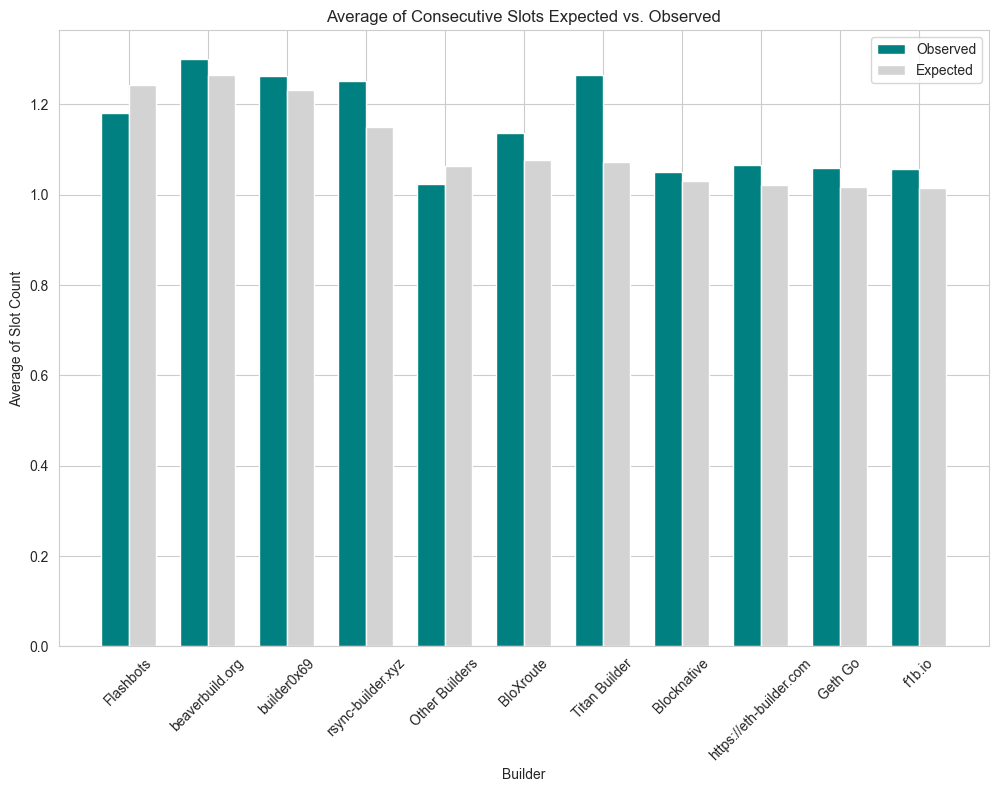

In [445]:
observed_occurence.head()

# Multiply each cell by its column name (consecutive slots)
weighted_oo = observed_occurence.mul(observed_occurence.columns, axis=1)
weighted_eo = expected_occurence.mul(expected_occurence.columns, axis=1)

# Sum the results for each row to get the total weighted count
weighted_sums_oo = weighted_oo.sum(axis=1)
weighted_sums_eo = weighted_eo.sum(axis=1)

# Sum the unweighted counts for each row
total_counts_oo = observed_occurence.sum(axis=1)
total_counts_eo = expected_occurence.sum(axis=1)

# Calculate the weighted average for each row
weighted_averages_oo = weighted_sums_oo / total_counts_oo
weighted_averages_eo = weighted_sums_eo / total_counts_eo

print("Observed Weighted Averages:")
print(weighted_averages_oo)
print("\nExpected Weighted Averages:")
print(weighted_averages_eo)

# Visualization
# Bar chart parameters
bar_width = 0.35  # Width of the bars
index = np.arange(len(weighted_averages_oo))  # Index for the builder

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(index - bar_width/2, weighted_averages_oo, bar_width, label='Observed', color='teal')
bars2 = ax.bar(index + bar_width/2, weighted_averages_eo, bar_width, label='Expected', color='#D3D3D3')

# Adding labels and titles
ax.set_xlabel('Builder')
ax.set_ylabel('Average of Slot Count')
ax.set_title('Average of Consecutive Slots Expected vs. Observed')
ax.set_xticks(index)
ax.set_xticklabels(weighted_averages_oo.index)
ax.legend()

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [11]:
# [Analysis & Visualization]

# Find the 10th and 90th percentiles to set as color limits
vmin, vmax = np.percentile(relative_deviation.fillna(0).values, [5, 95])

fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(relative_deviation, cmap='coolwarm', vmin=vmin, vmax=vmax)  # Set color scale limits
fig.colorbar(cax)
ax.set_title('Heatmap of Relative Deviation (%)')

# Set ticks and labels
ax.set_xticks(np.arange(len(relative_deviation.columns)))
ax.set_yticks(np.arange(len(relative_deviation.index)))

ax.set_xticklabels(relative_deviation.columns)
ax.set_yticklabels(relative_deviation.index)

plt.xlabel('Consecutive Slots')
plt.ylabel('Builders')
plt.xticks(rotation=90)

plt.show()


NameError: name 'relative_deviation' is not defined

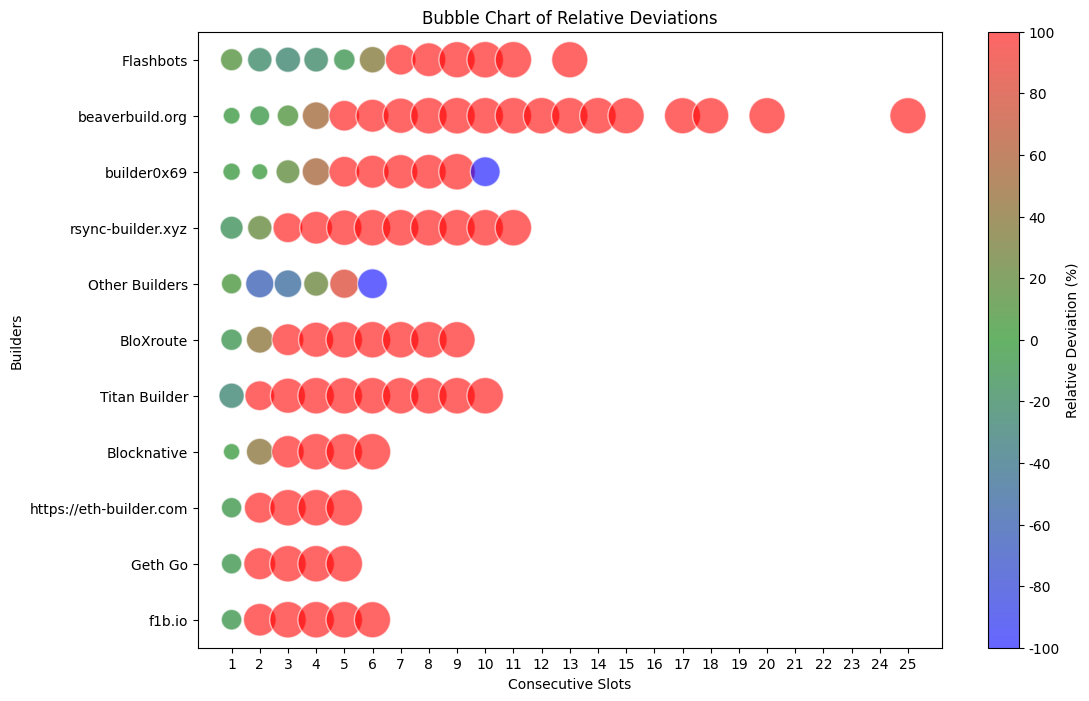

In [26]:
## [Data Visualization] Relative Deviation


# Reverse the index for plotting (builders from bottom to top)
relative_deviation = relative_deviation.iloc[::-1]

# Prepare grid coordinates for plotting, taking into account the reversed DataFrame
x, y = np.meshgrid(np.arange(len(relative_deviation.columns)), np.arange(len(relative_deviation.index)))

# Flatten the arrays for easy plotting
x = x.flatten()
y = y.flatten()
size = relative_deviation.values.flatten()  # Flatten the size data

# Ensure all size values are within the desired range [-1000, 1000]
capped_size = np.clip(size, -1000, 1000)

# Logarithmic scaling for sizes; adding 1 to ensure no log(0) issues
scaled_sizes = np.log(np.abs(capped_size) + 1) * 100

# Define a custom color map: blue (negative), green (zero deviation), red (positive)
colors = ["blue", "green", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors)
norm = mcolors.Normalize(vmin=-100, vmax=100)  # Set color normalization

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
bubble = ax.scatter(x, y, s=scaled_sizes, c=capped_size, cmap=cmap, norm=norm, alpha=0.6, edgecolors="w", linewidth=1)

# Color bar setup
cbar = fig.colorbar(bubble)
cbar.set_label('Relative Deviation (%)')
tick_values = np.linspace(-100, 100, num=11)  # Generates 7 evenly spaced ticks
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f"{v:.0f}" for v in tick_values])

# Set ticks and labels
ax.set_xticks(np.arange(len(relative_deviation.columns)))
ax.set_yticks(np.arange(len(relative_deviation.index)))
ax.set_xticklabels(relative_deviation.columns)
ax.set_yticklabels(relative_deviation.index)  
ax.set_xlabel('Consecutive Slots')
ax.set_ylabel('Builders')
ax.set_title('Bubble Chart of Relative Deviations')

plt.show()

In [389]:
relative_deviation.values.flatten()

array([ 1.19871150e+01, -2.13228124e+01, -2.64826525e+01, -2.27892653e+01,
       -9.49820789e+00,  3.88577828e+01,  1.67123288e+02,  5.29629630e+02,
        2.75000000e+02,  2.90000000e+03,  1.90000000e+03,             nan,
        9.00000000e+02,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan, -3.41562263e+00, -6.73019137e+00,  9.90069820e+00,
        5.18679588e+01,  1.28501629e+02,  2.58900145e+02,  6.12837838e+02,
        1.56666667e+03,  5.15000000e+03,  5.90000000e+03,  4.90000000e+03,
        2.90000000e+03,  4.90000000e+03,  1.90000000e+03,  9.00000000e+02,
                   nan,  9.00000000e+02,  9.00000000e+02,             nan,
        9.00000000e+02,             nan,             nan,             nan,
                   nan,  9.00000000e+02, -3.58848543e+00, -2.89908153e+00,
        1.75332685e+01,  

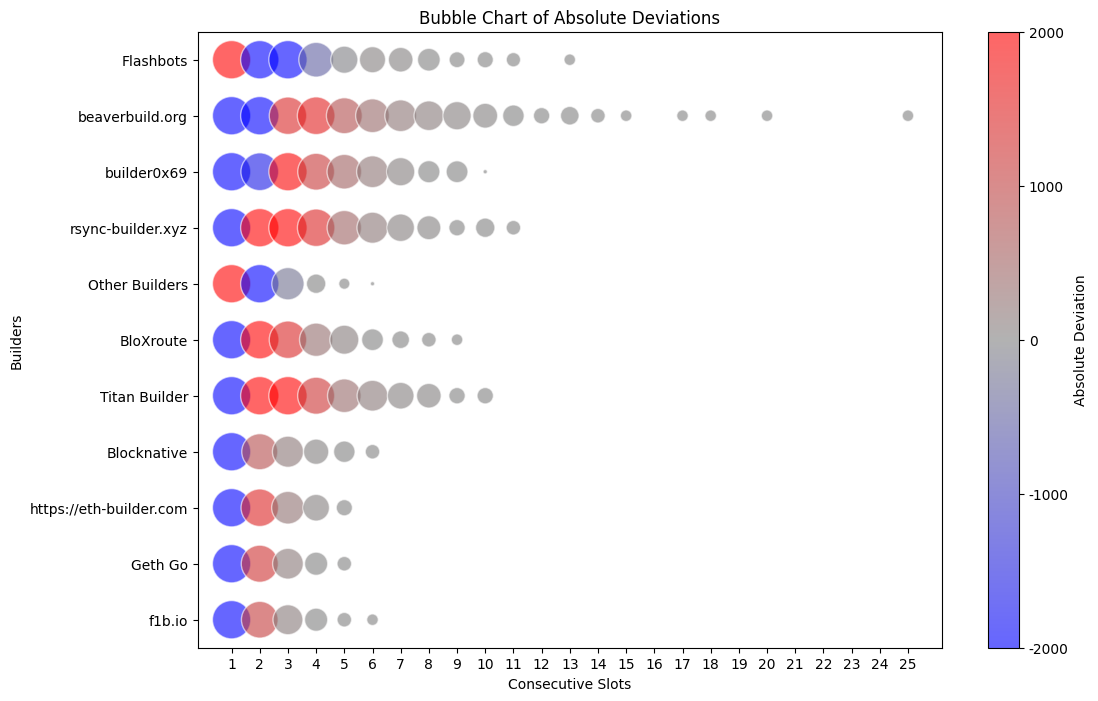

In [27]:
## [Data Visualization] Make graphic

# Reverse the index for plotting (builders from top to bottom)
difference_df_inv = difference_df.iloc[::-1]
builders = difference_df_inv.index

# Prepare grid coordinates for plotting, considering the reversed DataFrame
x, y = np.meshgrid(np.arange(len(difference_df_inv.columns)), np.arange(len(builders)))

# Flatten the arrays for easy plotting
x = x.flatten()
y = y.flatten()

# Cap and flatten the size data
size = difference_df_inv.values.flatten()  # Flatten the size data first
capped_sizes = np.clip(size, a_min=-2000, a_max=2000)  # Cap values

# Apply a logarithmic transformation to scale the sizes, adding 1 to avoid log(0)
scaled_sizes = np.log(np.abs(capped_sizes) + 1) * 100  # Scale factor for visibility

# Define a custom color map with blue, grey, and red
colors = ["blue", "grey", "red"]
cmap = mcolors.LinearSegmentedColormap.from_list("", list(zip([0.0, 0.5, 1.0], colors)))
norm = mcolors.TwoSlopeNorm(vmin=-2000, vcenter=0, vmax=2000)  # Normalized from -30 to +30

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 8))
bubble = ax.scatter(x, y, s=scaled_sizes, c=capped_sizes, cmap=cmap, norm=norm, alpha=0.6, edgecolors="w", linewidth=1)

# Add a color bar
cbar = fig.colorbar(bubble)
cbar.set_label('Absolute Deviation')
cbar.set_ticks([-2000, -1000, 0, 1000, 2000])
cbar.set_ticklabels(['-2000', '-1000', '0', '1000', '2000'])

# Set ticks and labels
ax.set_xticks(np.arange(len(difference_df_inv.columns)))
ax.set_yticks(np.arange(len(builders)))
ax.set_xticklabels(difference_df_inv.columns)
ax.set_yticklabels(builders)  # Labels are automatically correct with the DataFrame reversed
ax.set_xlabel('Consecutive Slots')
ax.set_ylabel('Builders')
ax.set_title('Bubble Chart of Absolute Deviations')

plt.show()

<Figure size 1200x600 with 0 Axes>

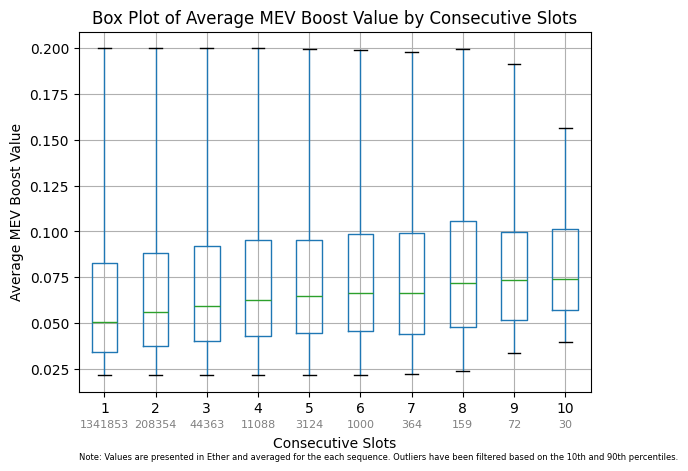

In [29]:
# [Analysis] - Payment for consecutive slots

ca_df = consecutive_analysis

lower_bound = ca_df['avg_mevboost_value'].quantile(0.1)
upper_bound = ca_df['avg_mevboost_value'].quantile(0.9)

# Filter out outliers - important to include in descriptive text!
filtered_ca_df = ca_df[(ca_df['avg_mevboost_value'] >= lower_bound) & (ca_df['avg_mevboost_value'] <= upper_bound)]


grouped = filtered_ca_df.groupby('consecutive_slots')['avg_mevboost_value'].describe()

# Optional: filter for the first 10 slots
filtered_ca_df = filtered_ca_df[filtered_ca_df['consecutive_slots'] <= 10]

# Convert to ETH
filtered_ca_df['avg_mevboost_value'] = filtered_ca_df['avg_mevboost_value'] / 10**18

#print("Grouped Statistics:")
#print(grouped)

# Create a box plot for 'avg_mevboost_value' across different 'consecutive_group'
plt.figure(figsize=(12, 6))
boxplot = filtered_ca_df.boxplot(column='avg_mevboost_value', by='consecutive_slots', grid=True, whis=3)
plt.title('Box Plot of Average MEV Boost Value by Consecutive Sequence Length')
plt.suptitle('')
plt.xlabel('Consecutive Slots', labelpad=15)
plt.ylabel('Average MEV Boost Value')
plt.figtext(0.1, 0.01, "Note: Values are presented in Ether and averaged for the each sequence. Outliers have been filtered based on the 10th and 90th percentiles.", 
            ha="left", fontsize=6, color="black")
plt.yscale('linear')

# Annotate sample sizes below the x-axis
slot_counts_boxplot = filtered_ca_df['consecutive_slots'].value_counts().sort_index()
for i, slot in enumerate(slot_counts_boxplot.index):
        plt.annotate(str(slot_counts_boxplot[slot]), (i+1, min(filtered_ca_df['avg_mevboost_value']) * 0.95), textcoords="offset points", xytext=(0,-30), ha='center', va='top', fontsize=8, color='grey')
plt.show()
plt.clf()

    Consecutive Slots  Average MEV-Boost Value  Median MEV-Boost Value
0                   1             1.273057e+17            5.020768e+16
1                   2             1.276951e+17            5.915567e+16
2                   3             1.373888e+17            6.483998e+16
3                   4             1.371747e+17            6.919731e+16
4                   5             1.382367e+17            7.072838e+16
5                   6             1.495245e+17            7.269584e+16
6                   7             1.867136e+17            7.434344e+16
7                   8             1.042068e+17            7.386823e+16
8                   9             1.462563e+17            8.300487e+16
9                  10             1.325392e+17            8.024483e+16
10                 11             7.602389e+16            5.677223e+16
11                 12             1.072440e+17            9.962547e+16
12                 13             8.366228e+16            7.197352e+16
13    

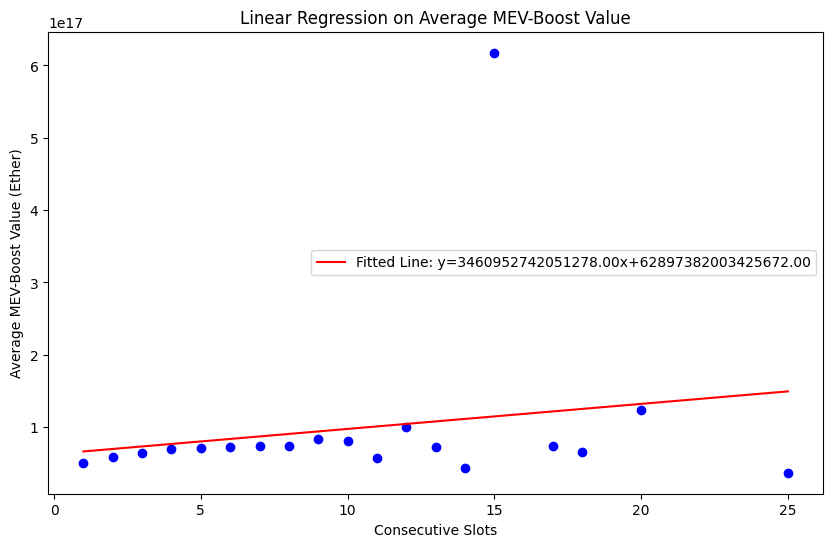

In [77]:
# Sanity Check

from scipy import stats

ca_df_all = ca_df.groupby('consecutive_slots')['avg_mevboost_value'].agg(['mean', 'median']).reset_index()

# Rename the columns for better understanding
ca_df_all.columns = ['Consecutive Slots', 'Average MEV-Boost Value', 'Median MEV-Boost Value']

# Display the averages and medians
print(ca_df_all)

# Assuming ca_df_all is already prepared and loaded with 'Consecutive Slots' and 'Average MEV-Boost Value'
x = ca_df_all['Consecutive Slots']
y = ca_df_all['Median MEV-Boost Value']

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Calculate R-squared
r_squared = r_value**2

# Print the slope and intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_squared}")

# Plot the data along with the fitted line
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue')  # Plot the raw data
plt.plot(x, intercept + slope*x, 'r', label=f'Fitted Line: y={slope:.2f}x+{intercept:.2f}')  # Plot the regression line
plt.title('Linear Regression on Average MEV-Boost Value')
plt.xlabel('Consecutive Slots')
plt.ylabel('Average MEV-Boost Value (Ether)')
plt.legend()
plt.show()


/var/folders/bv/r1z7kms93x38d9q20_h440fc0000gq/T/ipykernel_23821/259152644.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_builders_df['slot_builder'] = selected_builders_df['consecutive_slots'].astype(str) + " - " + selected_builders_df['builder']
/var/folders/bv/r1z7kms93x38d9q20_h440fc0000gq/T/ipykernel_23821/259152644.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_builders_df['slot_builder'] = pd.Categorical(selected_builders_df['slot_builder'],
/var/folders/bv/r1z7kms93x38d

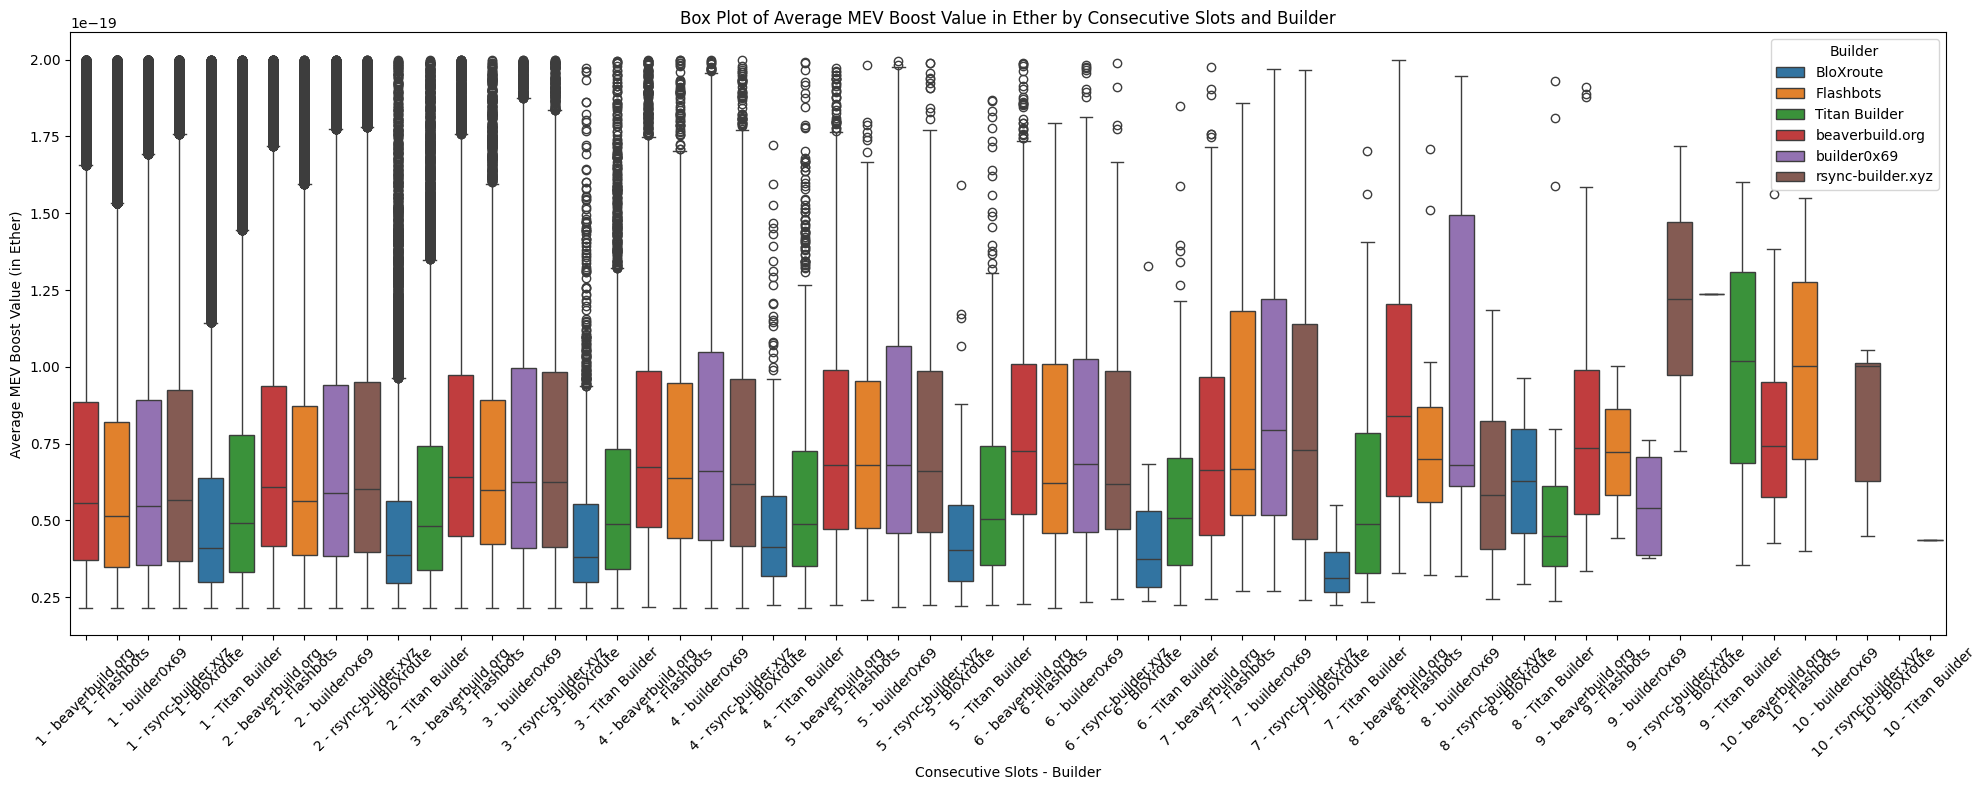

In [51]:
# [Visualization]

# Specify the builders you are interested in
selected_builders = ['beaverbuild.org', 'Flashbots', 'builder0x69', 'rsync-builder.xyz'#,'Other Builders' 
                     ,'BloXroute', 'Titan Builder' 
                    #, 'Blocknative', 'https://eth-builder.com', 'Geth Go', 'f1b.io '
                    ]  # Adjust the list as necessary

# Filter the DataFrame to include only the selected builders
selected_builders_df = filtered_ca_df[filtered_ca_df['builder'].isin(selected_builders)]

# Create a new column that will help in ordering the plots correctly by combining 'consecutive_slots' and 'builder_name'
selected_builders_df['slot_builder'] = selected_builders_df['consecutive_slots'].astype(str) + " - " + selected_builders_df['builder']
selected_builders_df['slot_builder'] = pd.Categorical(selected_builders_df['slot_builder'],
                                                      [f"{i} - {b}" for i in sorted(selected_builders_df['consecutive_slots'].unique()) for b in selected_builders])

# Convert 'avg_mevboost_value' from Wei to Ether
selected_builders_df['avg_mevboost_value'] = selected_builders_df['avg_mevboost_value'] / 10**18

# Plotting using seaborn for better control over aesthetics
plt.figure(figsize=(20, 8))
sns.boxplot(x='slot_builder', y='avg_mevboost_value', data=selected_builders_df, hue='builder', dodge=False)
plt.title('Box Plot of Average MEV Boost Value in Ether by Consecutive Slots and Builder')
plt.xlabel('Consecutive Slots - Builder')
plt.ylabel('Average MEV Boost Value (in Ether)')
plt.xticks(rotation=45)
plt.legend(title='Builder')
plt.tight_layout()
plt.show()
plt.clf()

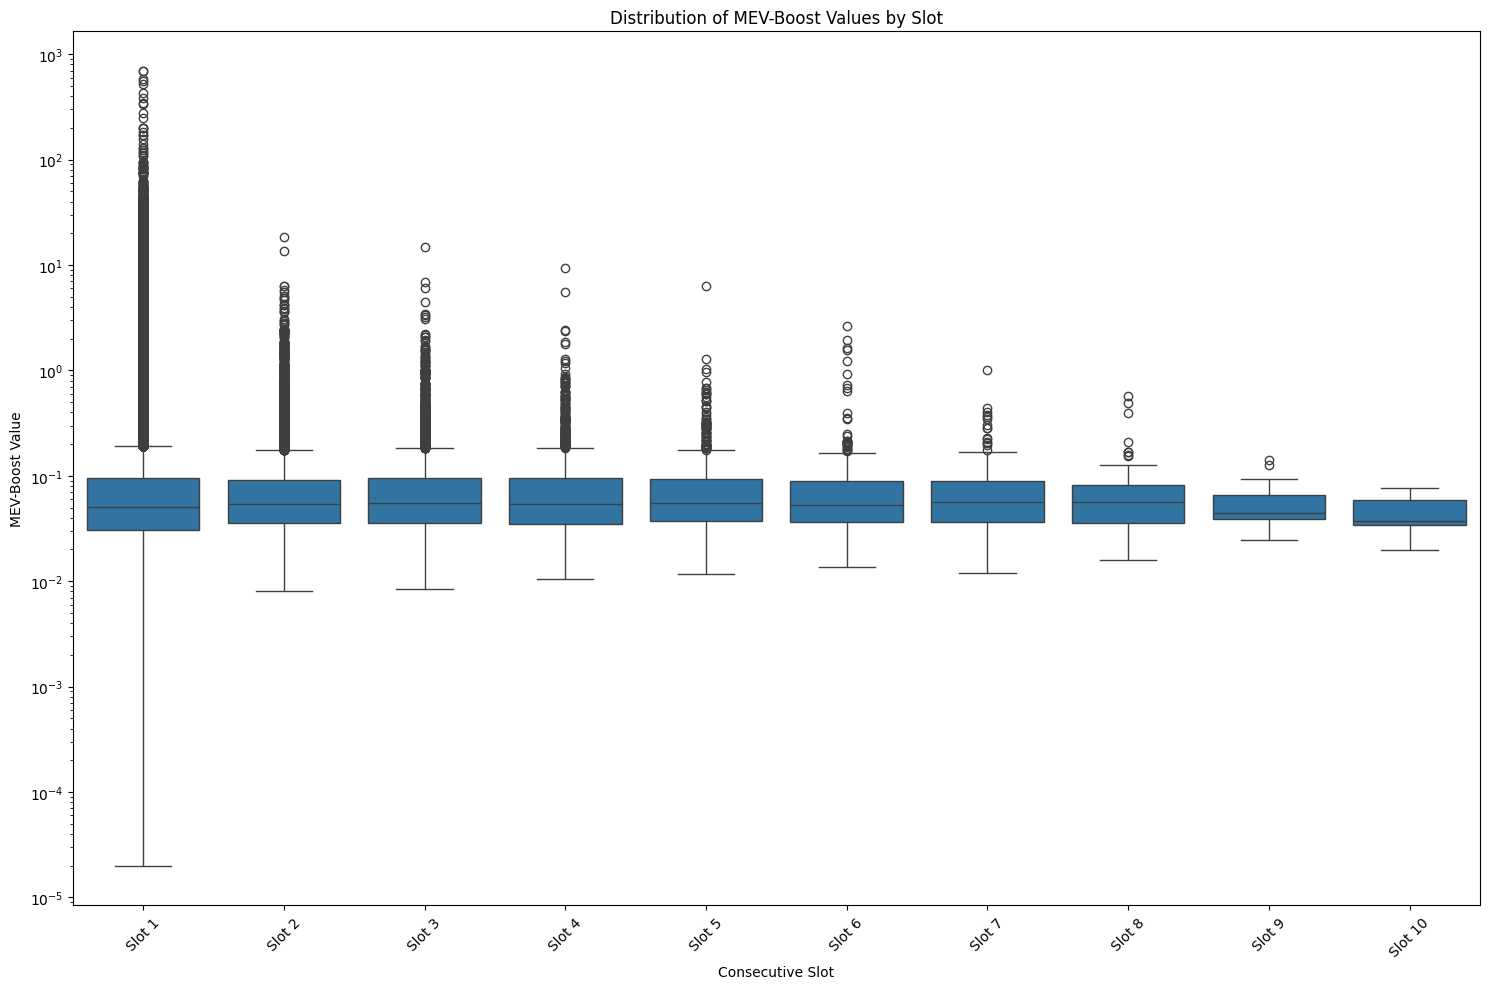

In [18]:
# [Analysis & Visualization] MEV Payment on average per slot position
# In this analysis MEV payments are ordered via the position in a consecutive sequence and then the average is taken

ca_df_2 = consecutive_analysis

# Function to filter outliers
def filter_outliers(values):
    values = pd.Series(values)
    if len(values) > 0:
        lower_bound = values.quantile(0.1)
        upper_bound = values.quantile(0.9)
        return values[(values >= lower_bound) & (values <= upper_bound)].tolist()
    return values.tolist()

# Applying the function to filter out the outliers
ca_df_2['filtered_mevboost_values'] = ca_df_2['all_mevboost_values'].apply(filter_outliers)

# Convert values from Wei to Ether 
ca_df_2['filtered_mevboost_values'] = ca_df_2['filtered_mevboost_values'].apply(lambda x: [y / 10**18 for y in x])

# Prepare the data, ensuring only the first 10 values are used
expanded_df = pd.DataFrame(ca_df_2['filtered_mevboost_values'].tolist())
max_columns = min(10, expanded_df.shape[1])  # Limit columns to 10 or the maximum available if less than 10
expanded_df = expanded_df.iloc[:, :max_columns]
expanded_df.columns = [f'Slot {i+1}' for i in range(max_columns)]

# Convert the DataFrame from wide format to long format for easier plotting with seaborn
melted_df = expanded_df.melt(var_name='Consecutive Slot', value_name='MEV-Boost Value')

## Ensure no zero or negative values for logarithmic scale
# melted_df['MEV-Boost Value'] = melted_df['MEV-Boost Value'].clip(lower=0.0001)  # Replace 0 and negative values with 0.0001

# Plotting using seaborn
plt.figure(figsize=(15, 10))
sns.boxplot(x='Consecutive Slot', y='MEV-Boost Value', data=melted_df)
plt.xticks(rotation=45)  # Rotate position labels for better readability
plt.title('Distribution of MEV-Boost Values by Slot')
plt.yscale('log')  # Apply logarithmic scale to the y-axis
plt.tight_layout()
plt.show()

In [14]:
# Sanity Check


# Calculate the mean MEV-Boost Value for each slot
average_mev_per_slot = melted_df.groupby('Consecutive Slot')['MEV-Boost Value'].mean()

# Convert the Series to DataFrame for better formatting and potential further processing
average_mev_per_slot_df = average_mev_per_slot.reset_index()
average_mev_per_slot_df.columns = ['Consecutive Slot', 'Average MEV-Boost Value']

# Display the averages
print(average_mev_per_slot_df)


  Consecutive Slot  Average MEV-Boost Value
0           Slot 1                 0.126146
1          Slot 10                 0.045610
2           Slot 2                 0.098060
3           Slot 3                 0.100067
4           Slot 4                 0.099041
5           Slot 5                 0.099340
6           Slot 6                 0.105352
7           Slot 7                 0.088059
8           Slot 8                 0.083432
9           Slot 9                 0.055683


In [ ]:
## Sanity Check - Attention: takes long time

# Function to plot payment trends within sequences
def plot_payment_trends(data):
    plt.figure(figsize=(12, 6))
    for index, row in data.iterrows():
        plt.plot(row['all_mevboost_values'], label=f'Seq {index + 1} (Len {len(row["all_mevboost_values"])})')

    plt.title('MEV Boost Payments in Sequences')
    plt.xlabel('Position in Sequence')
    plt.ylabel('MEV Boost Payment')
    plt.legend(title="Sequence")
    plt.show()

plot_payment_trends(consecutive_analysis)

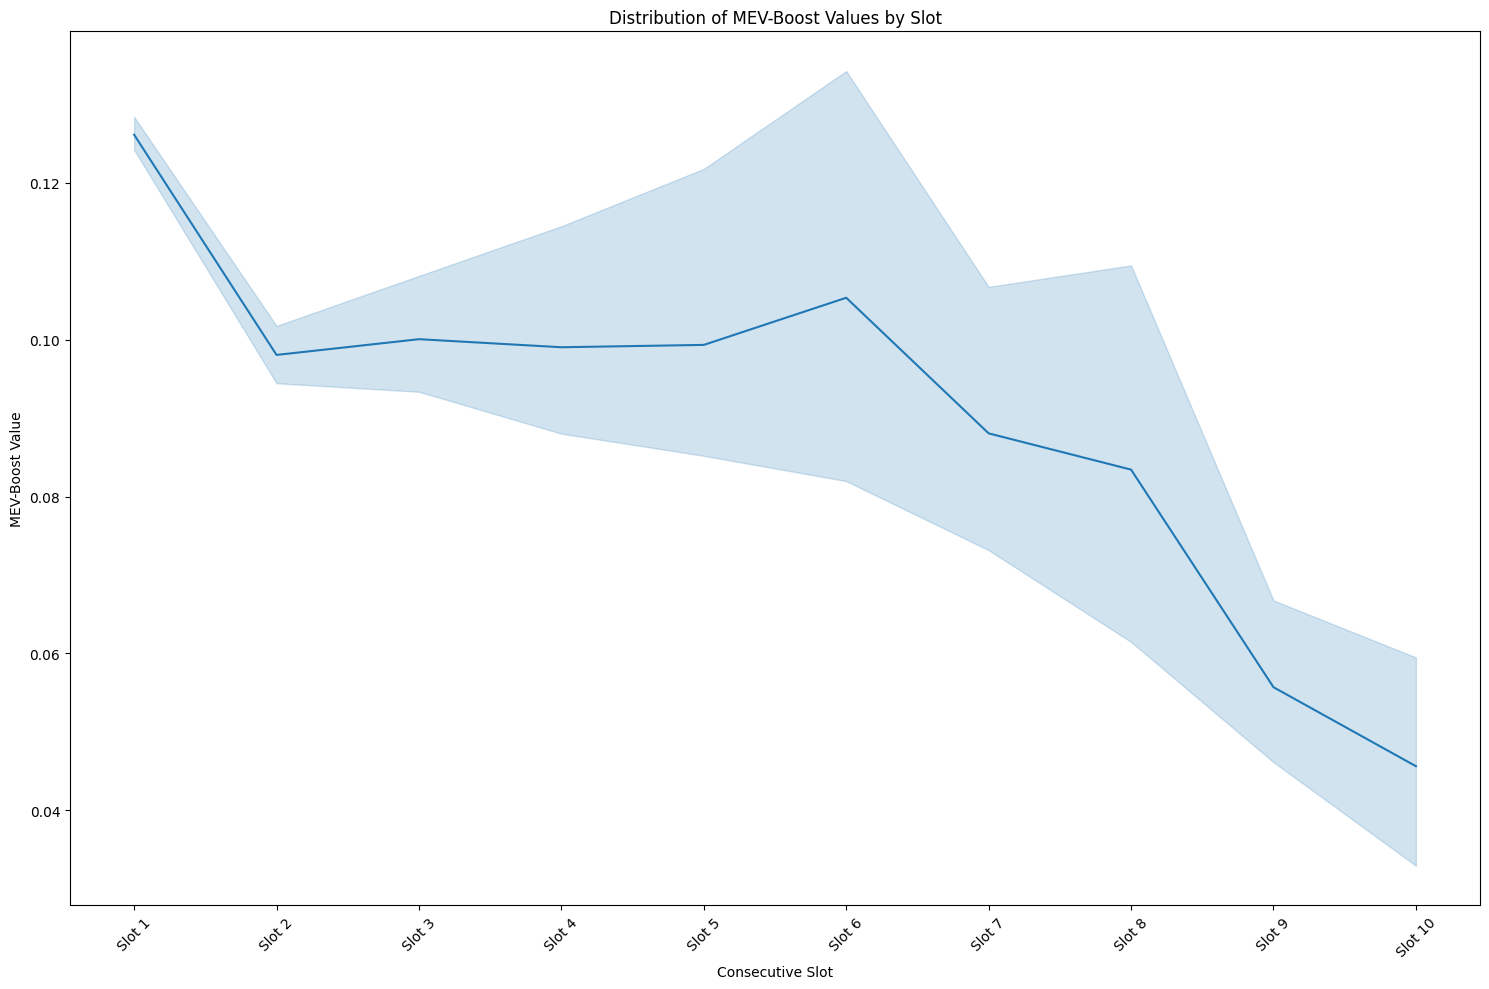

In [24]:
## [Analysis] 
# Requirement: previous analysis needs to be run that generates ca_df_2 dataframe

# Assuming 'consecutive_analysis' contains a column 'all_mevboost_values' with lists of MEV payments


# Expanding the filtered and converted lists into a DataFrame
expanded_df = pd.DataFrame(ca_df_2['filtered_mevboost_values'].tolist())
expanded_df = expanded_df.iloc[:, :10]
expanded_df.columns = [f'Slot {i+1}' for i in range(expanded_df.shape[1])]

# Converting the DataFrame from wide format to long format for easier plotting with seaborn
melted_df = expanded_df.melt(var_name='Consecutive Slot', value_name='MEV-Boost Value')

# Ensure no zero or negative values for logarithmic scale (replacing 0 and negative values with a small number)
melted_df['MEV-Boost Value'] = melted_df['MEV-Boost Value'].clip(lower=0.0000001)

# Plotting using seaborn
plt.figure(figsize=(15, 10))
sns.lineplot(x='Consecutive Slot', y='MEV-Boost Value', data=melted_df)
plt.xticks(rotation=45)  # Rotate position labels for better readability
plt.title('Distribution of MEV-Boost Values by Slot')
plt.yscale('linear')  # Apply logarithmic scale to the y-axis
plt.tight_layout()
plt.show()


In [23]:
## [Analysis] Statistical Testing of trends within slots

from scipy.stats import linregress

# Convert position labels to numeric
mean_payments_by_position['Position Numeric'] = mean_payments_by_position['Position'].str.extract('(\d+)').astype(int)

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(mean_payments_by_position['Position Numeric'], mean_payments_by_position['Average Payment'])

print(f"Slope: {slope}")
print(f"p-value: {p_value}")

# Testing the hypothesis that slope is significantly less than 0
if p_value < 0.05 and slope < 0:
    print("Significant decreasing trend.")
else:
    print("No significant decreasing trend.")


NameError: name 'mean_payments_by_position' is not defined

In [ ]:
## [Sanity Check] Search for individual slots to cross-check with https://beaconcha.in/

# Filter for rows with X consecutive slots
num_consecutive_slots = 10
resp_builder = "Titan Builder"
rows_with_consecutive_slots = consecutive_analysis_filtered[
    (consecutive_analysis_filtered['consecutive_slots'] == num_consecutive_slots) & 
    (consecutive_analysis_filtered['builder'] == resp_builder)
]

# Extract the slot numbers for these rows
slot_numbers_for_consecutive_slots = rows_with_consecutive_slots['slot_numbers']

slot_numbers_for_consecutive_slots.head()
#mev_boost_consecutive.head(5)



In [ ]:
print(mev_boost_consecutive[mev_boost_consecutive['slot'] == 6737452]) 

,builder,consecutive_group,consecutive_slots,avg_mevboost_value,all_mevboost_values,slot_numbers,block_numbers,filtered_mevboost_values
0,0x805492e33b23293a17d0defd5be6abe0449390e188fd...,1907012,1,2.444390e+17,[2.4443902484444182e+17],[6913571],[17728649.0],[0.24443902484444183]
1,0x812b4a9b2bec0599938741900515cc5aba92421aa284...,593443,1,2.854366e+16,[2.854366332127313e+16],[5365566],[16198678.0],[0.028543663321273127]
2,0x812b4a9b2bec0599938741900515cc5aba92421aa284...,593559,1,4.825742e+16,[4.82574248835109e+16],[5365690],[16198801.0],[0.0482574248835109]
3,0x812b4a9b2bec0599938741900515cc5aba92421aa284...,593571,1,4.664750e+16,[4.664749834050688e+16],[5365702],[16198813.0],[0.04664749834050688]
4,0x812b4a9b2bec0599938741900515cc5aba92421aa284...,593581,1,2.956385e+16,[2.9563853761376024e+16],[5365714],[16198825.0],[0.029563853761376022]
